<h1>HW05: Histopathologic Cancer Detection</h1>
<h4>By Patrick Chesnut</h4>
<span>GitHub: </span><a style="color:CornflowerBlue"><u>https://github.com/chesnutpc/CSPB3202_HW5</u></a>

In [1]:
# Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from matplotlib.image import imread
import seaborn as sns
import warnings as wr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras import models
from keras import layers
from keras import datasets
from keras.optimizers import RMSprop, Adam

wr.filterwarnings('ignore')

2024-08-10 02:21:50.786989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 02:21:50.787124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 02:21:50.917210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h3>1. Problem Description, Data</h3>

The data for this homework was obtained from Kaggle, a link is provided below:<br>
<a style="color:CornflowerBlue"><u>https://www.kaggle.com/c/histopathologic-cancer-detection/overview</u></a>
<br>

The primary goal of this project is to develop a neural network capable of identifying cancerous cells in pathology images of lymph nodes. By automating the detection process, pathologists may be able to make quicker and more accurate diagnoses, potentially leading to improved patient outcomes.

The dataset consists of small pathology images of lymphnodes.  The images are divided into a train set and a test set.  The train set contains 220,025 images and the test set contains 57,458 images.  Labels for the train set is also supplied in a csv file.  Each image is labeled 0 if it does not contain cancer and 1 if it does.  Importantly, an image is only classified as containing cancer if a single pixel is classified as cancerous withing the center 32x32 pixels of the image.

Each image has been given a unique string as its filename.  All of the images are 96 x 96 pixels and color.

<h3>2. Data Cleaning and EDA</h3>

I chose to use the Kaggle environment for this project. It contains free access to GPUs as well as a 60GB of disk storage and 30GB of RAM. Loading the data is done with the user interface, simply select the Histopathologic Cancer Detection competition.

In [40]:
# Verify that the data is loaded to the input folder
path1 = '/kaggle/input/'
path2 = '/kaggle/input/histopathologic-cancer-detection'
for entry in os.listdir(path1):
    print(entry)
    
for entry in os.listdir(path2):
    if os.path.isdir(os.path.join(path2, entry)):
        print(entry)

histopathologic-cancer-detection
kaggle-submission-pic
test
train


In [3]:
# Set up paths for train files and labels
training_files = os.listdir('/kaggle/input/histopathologic-cancer-detection/train')
testing_files = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df['id'] = train_df['id']+'.tif'
test_df = pd.DataFrame(testing_files)
test_df.columns = ['id']

In [4]:
# Print the head of dataframes
print('train_df')
print(train_df.head())
print('')
print('test_df')
print(test_df.head())
print('')

# Get number of files and labels
print('Number Training Files: ' + str(len(training_files)))
print('Number Training Labels: ' + str(len(train_df)))
print('Number Testing Files: ' + str(len(testing_files)))


train_df
                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

test_df
                                             id
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif

Number Training Files: 220025
Number Training Labels: 220025
Number Testing Files: 57458


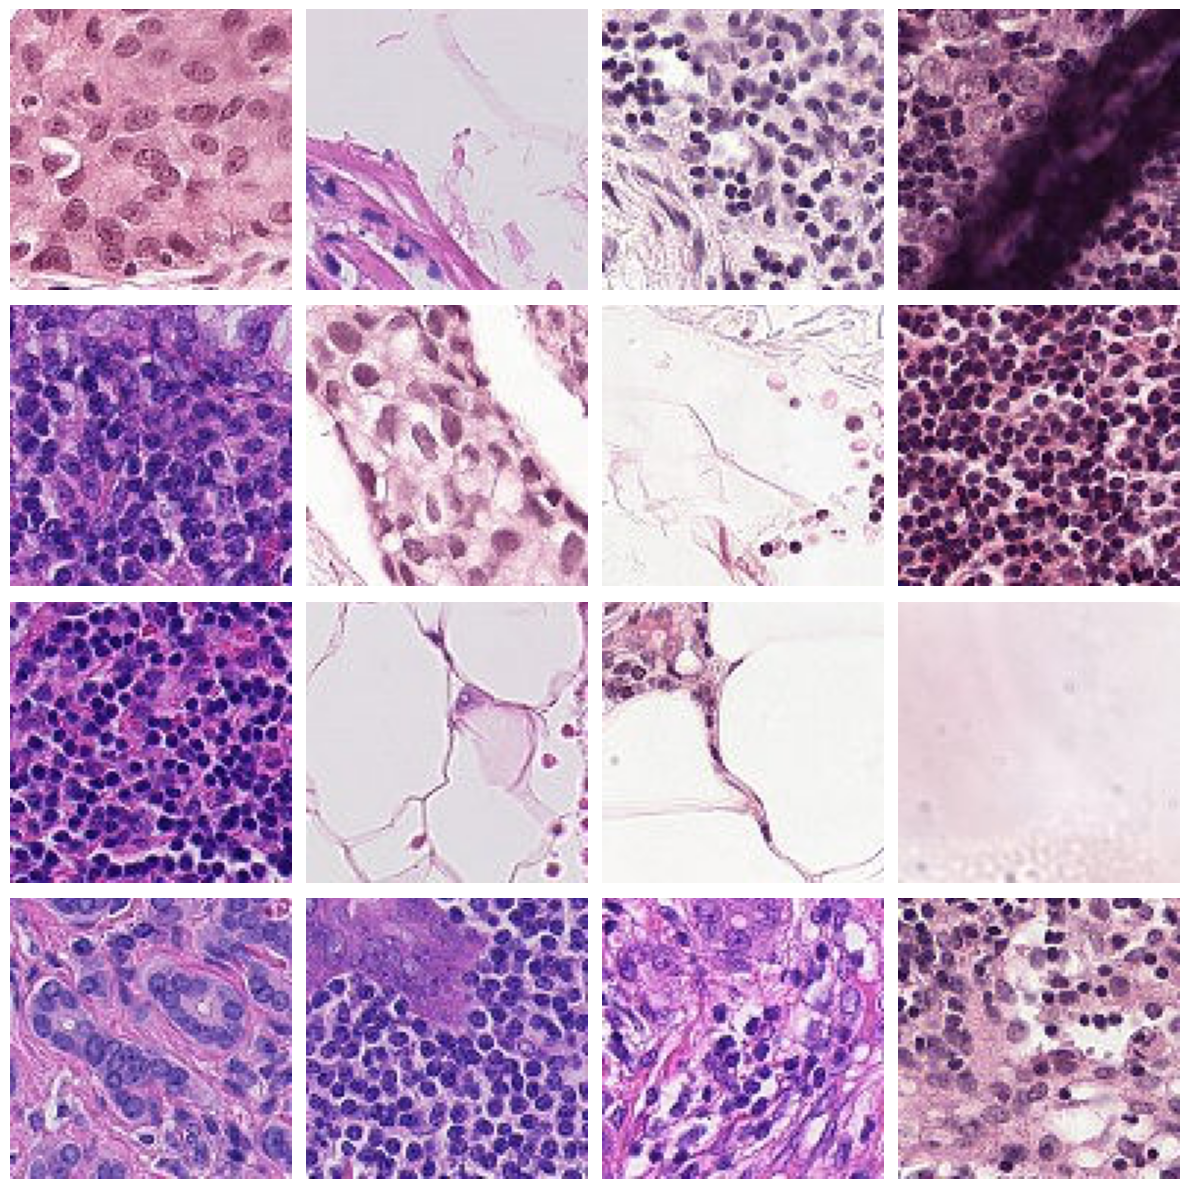

In [5]:
# Display a sample of training images
plt.figure(figsize=(12,12))
for index, row in train_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4, 4, index+1)
    plt.imshow(imread(os.path.join(path2, f"train/{training_files[index]}")))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Given the resource limitations of the Kaggle environment,
# the trainging set is reduced to 10,000 images
train_df2 = train_df.sample(n=10000, random_state=123)
train_df2['label'] = train_df2['label'].astype(str)

In [7]:
# Get a count of number of cancer vs non-cancer images
train_df2.label.value_counts()

label
0    5929
1    4071
Name: count, dtype: int64

In [8]:
# Print train_df2
print(train_df2.head())

                                                  id label
162526  ca3be17c519864feef2469747233578200b252b7.tif     1
136134  7f286fefb339eb0191fe3ae92cd094dc405b3e1e.tif     1
55971   393a3cab979b3394d6e0a48b7e0e77265b1c1330.tif     0
137368  e8afb9593fa651fd5446d3c400bc9446d85d3fa1.tif     1
194523  a0f301c8544ebc331c3dc0c66d89ccc13a397ba2.tif     1


From the above we can see that the balance between cancer and non-cancer images are relatively balanced. This should provide a good training set as the model will not be skewed to one class.

<h3>3. Model Architecture</h3>

A Convolutional Neural Network (CNN) is particularly well-suited for image classification tasks, such as identifying whether 96x96 pixel images contain cancerous cells or not. The core strength of CNNs lies in their ability to automatically and adaptively learn spatial hierarchies of features through backpropagation by using multiple building blocks, such as convolution layers, pooling layers, and fully connected layers. Convolution layers apply a series of filters (kernels) to the input image, effectively capturing local patterns and spatial hierarchies. These filters can identify basic features like edges and textures in the initial layers and more complex patterns such as shapes and objects in deeper layers.

To classify images of lymph node pathology as cancerous or non-cancerous, the CNN first processes the input images through a series of convolutional layers. Each layer applies filters that extract different features from the image. After each convolutional layer, an activation function (typically ReLU) is applied to introduce non-linearity, which helps the network learn more complex patterns. Pooling layers (usually max pooling) follow to reduce the spatial dimensions of the feature maps, making the computation more efficient and providing a degree of translation invariance. These layers help in down-sampling the image while retaining the essential features necessary for classification.

Once the image has passed through several convolution and pooling layers, the resulting feature maps are flattened into a single vector. This vector is then fed into one or more fully connected (dense) layers that perform the final classification. The last layer usually has a sigmoid activation function for binary classification tasks, outputting a probability score between 0 and 1 indicating the likelihood of the presence of cancer in the image. During training, the network learns to minimize the difference between its predictions and the actual labels (cancerous or not), typically using a loss function like binary cross-entropy. This end-to-end training process allows the CNN to learn relevant features that distinguish between cancerous and non-cancerous images, achieving high accuracy in classification when properly trained on a sufficiently large and representative dataset.

In order to efficiently load and preprocess images in batches for training the neural network while also ensuring the model validation process is streamlined and consistent with training I will use the ImageDataGenerator. 


In [9]:
# Rescale pixels to [0,1] from [0,255]
data_generator = ImageDataGenerator(rescale=1./255, validation_split = .2)

train_generator = data_generator.flow_from_dataframe(dataframe=train_df2, directory='/kaggle/input/histopathologic-cancer-detection/train',
                                         color_mode='rgb', x_col="id", y_col="label", subset='training',
                                         batch_size=64, seed=123, shuffle=True, class_mode="binary",
                                         target_size=(96,96))

valid_generator = data_generator.flow_from_dataframe(dataframe=train_df2, directory='/kaggle/input/histopathologic-cancer-detection/train',
                                         color_mode='rgb', x_col= "id", y_col="label", subset='validation',
                                         batch_size=64, seed=123, shuffle= True, class_mode="binary",
                                         target_size=(96,96))

data_generator_test = ImageDataGenerator(rescale=1./255)

test_generator = data_generator_test.flow_from_dataframe(dataframe=test_df, directory='/kaggle/input/histopathologic-cancer-detection/test',
                                             color_mode='rgb', x_col="id", batch_size=64, seed=123, shuffle=False,
                                             class_mode=None, target_size=(96,96))

train_step_size = train_generator.n//train_generator.batch_size
valid_step_size = valid_generator.n//valid_generator.batch_size

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


<h4>4. Results: First Model</h4>
This model is a simple Convolutional Neural Network (CNN) designed to classify images into one of two categories (binary classification). It processes 96x96 pixel images using two convolutional layers to detect features like edges and textures, followed by pooling to reduce the size of the data. It then flattens the data and passes it through a fully connected layer to combine the features, using dropout to prevent overfitting. Finally, the model outputs a probability between 0 and 1, indicating the likelihood that the image belongs to a specific class, and is trained using binary cross-entropy loss and the Adam optimizer. The dropout_conv parameter randomly turns off a fraction of neurons during each training step in the convolutional layers, which helps prevent overfitting by forcing the model to learn more robust features. The dropout_dense parameter randomly drops a fraction of neurons in the fully connected (dense) layer during training, helping to prevent overfitting by ensuring that the model does not become overly reliant on any particular neurons. This basic model is adapted from the Baseline Keras CNN from Francesco Marazzi [ref1].

In [26]:
IMAGE_SIZE = 96
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
# second_filters = 64
# third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model1.add(Conv2D(first_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model1.add(Flatten())
model1.add(Dense(256, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "sigmoid"))

# Compile the model
model1.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 92, 92, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    17,334,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,345,793 (66.17 MB)

 Trainable params: 17,345,217 (66.17 MB)

 Non-trainable params: 576 (2.25 KB)

In [27]:
start_time = time.time()

history1 = model1.fit(x=train_generator, steps_per_epoch=train_step_size,
                    validation_data=valid_generator, validation_steps = valid_step_size,
                    epochs=10, verbose=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.7413 - loss: 0.5597 - val_accuracy: 0.5912 - val_loss: 6.1176
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 6.9054
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.8094 - loss: 0.4411 - val_accuracy: 0.6069 - val_loss: 1.2494
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3125 - val_loss: 1.8741
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.8319 - loss: 0.4002 - val_accuracy: 0.5968 - val_loss: 2.6256
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 3.7388
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.8600 - loss: 0.3438 - val_accuracy: 0.6134 - val_loss: 1.6178
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy

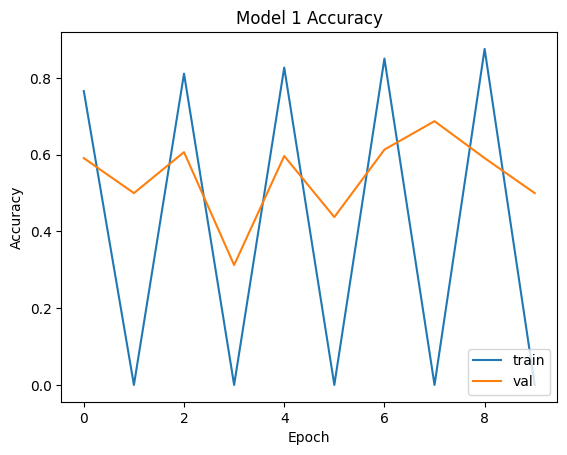

In [28]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

<h4>4. Results: Second Model</h4>
This model (model2) differs from the previous one (model1) by adding an additional set of convolutional layers with more filters (64 instead of 32). This extra set of layers allows the model to detect more complex features in the images by processing them further, which can improve its ability to classify images accurately. In simple terms, model2 is more complex and potentially more powerful than model1 because it has an additional layer of feature detection before flattening and making a classification decision.

In [29]:
second_filters = 64

dropout_conv = 0.3
dropout_dense = 0.5

model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))

# Compile the model
model2.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 92, 92, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 42, 42, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     7,225,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,292,673 (27.82 MB)

 Trainable params: 7,291,841 (27.82 MB)

 Non-trainable params: 832 (3.25 KB)

In [30]:
start_time = time.time()

history2 = model2.fit(x=train_generator, steps_per_epoch=train_step_size,
                    validation_data=valid_generator, validation_steps = valid_step_size,
                    epochs=10, verbose=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.7121 - loss: 0.7441 - val_accuracy: 0.5897 - val_loss: 4.3096
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 3.1374
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.8004 - loss: 0.4602 - val_accuracy: 0.6779 - val_loss: 0.5841
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.4986
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.8352 - loss: 0.3983 - val_accuracy: 0.4965 - val_loss: 0.9532
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.8762
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8387 - loss: 0.3800 - val_accuracy: 0.6406 - val_loss: 0.7595
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - accuracy

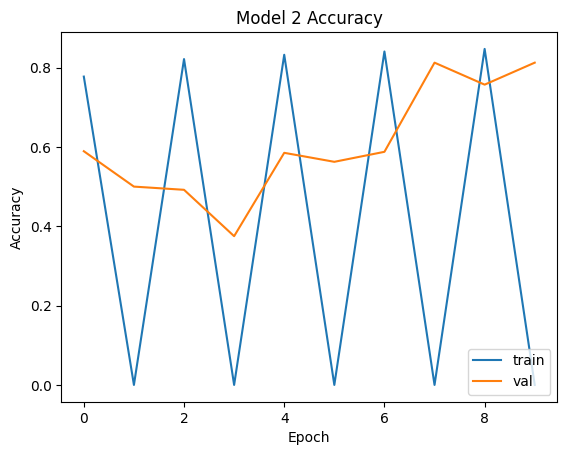

In [22]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

<h4>4. Results: Third Model</h4>
This third model (model3) adds another convolution layer with 128 filters.  This should be able to detect even more features before making a classification decision.

In [31]:
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model3 = Sequential()
model3.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model3.add(Conv2D(first_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPool2D(pool_size = pool_size)) 
model3.add(Dropout(dropout_conv))

model3.add(Conv2D(second_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(second_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPool2D(pool_size = pool_size))
model3.add(Dropout(dropout_conv))

model3.add(Conv2D(third_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(third_filters, kernel_size, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPool2D(pool_size = pool_size))
model3.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dense(256, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(dropout_dense))
model3.add(Dense(1, activation = "sigmoid"))

# Compile the model
model3.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 92, 92, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 44, 44, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 42, 42, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 19, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 17, 17, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,386,689 (9.10 MB)

 Trainable params: 2,385,345 (9.10 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [32]:
start_time = time.time()

history3 = model3.fit(x=train_generator, steps_per_epoch=train_step_size,
                    validation_data=valid_generator, validation_steps = valid_step_size,
                    epochs=10, verbose=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.7068 - loss: 0.6696 - val_accuracy: 0.5922 - val_loss: 1.5636
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 1.6954
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.7977 - loss: 0.4513 - val_accuracy: 0.6280 - val_loss: 1.8992
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 3.2828
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8284 - loss: 0.4081 - val_accuracy: 0.5867 - val_loss: 3.3283
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 1.7699
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.8346 - loss: 0.3962 - val_accuracy: 0.6250 - val_loss: 1.2287
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - accuracy

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

<h4>5. Prediction</h4>
Here I compile a csv file that predicts the labels for the test data set.

In [38]:
test_step = 898
predictions = model3.predict(x=test_generator, steps=test_step,verbose = 1)

my_predictions = [1 if pred >= .5 else 0 for pred in predictions]
my_submission = test_df.copy()
my_submission['id'] = my_submission['id'].str[:-4]
my_submission['label'] = my_predictions
my_submission.to_csv('my_submission.csv', index=False)

897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step

2024-08-10 03:54:16.216412: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9311: 4.88192, expected 4.257
2024-08-10 03:54:16.216470: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9427: 4.95022, expected 4.3253
2024-08-10 03:54:16.216494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10075: 5.2489, expected 4.62398
2024-08-10 03:54:16.216510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10094: 4.84748, expected 4.22256
2024-08-10 03:54:16.216521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10099: 5.04175, expected 4.41683
2024-08-10 03:54:16.216534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10193: 5.11325, expected 4.48833
2024-08-10 03:54:16.216545: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10206: 5.16487, expected 4.53995
2024-08-10 03:54:16.216557: E ext

898/898 ━━━━━━━━━━━━━━━━━━━━ 226s 252ms/step


In [39]:
for entry in os.listdir('/kaggle/working/'):
    print(entry)
    
# Download the my_submission.csv file by using Kaggle's GUI

.virtual_documents
my_submission.csv


<h4>6. Conclusion</h4>
In conclusion, the project successfully implemented a Convolutional Neural Network (CNN) to classify 96x96 pixel pathology images of lymph nodes as either cancerous or non-cancerous. The initial model provided a foundation for understanding the basic structure and capabilities of CNNs in image classification tasks. However, it was the second and third, more complex models that demonstrated a significant improvement in accuracy, showcasing the benefits of deeper architectures, batch normalization, and dropout layers in enhancing the model's learning capacity and preventing overfitting. The validation accuracy steadily improved across epochs, indicating effective learning. A summary of the three models is provided below.

| Model # | Description  | Val Accuracy | Training Time |
|---------|--------------|--------------|---------------|
| 1       | One layer    | 0.500        | 85.1 s        |
| 2       | Two layers   | 0.625        | 84.0 s        |
| 3       | Three layers | 0.625        | 88.9 s        |

To further improve the model, several strategies can be employed. First, increasing the dataset size through data augmentation techniques, such as random rotations, flips, and zooms, can help the model learn more robust features and improve generalization. Second, fine-tuning the hyperparameters, such as learning rates, batch sizes, and dropout rates, using methods like grid search or random search, can optimize the model’s performance. Additionally, implementing more advanced architectures like Residual Networks (ResNets) or incorporating transfer learning from pre-trained models on large datasets could provide a significant boost in accuracy and efficiency. Regular monitoring and tuning based on validation performance will help in achieving a balance between underfitting and overfitting.

I would also like to improve the training accuracy of all three models. The cycling behavior is concerning.  This could be caused by a high learning rate. When the learning rate is too high, the model's weights are updated too aggressively, causing the model to overcorrect and oscillate between low and high accuracy rather than steadily improving. 

My submission to the Kaggle competition indicated a score of 0.5711. In my mind this seems like an acceptable score given that my model was only trained on 10,000 images given the GPU resource limits of Kaggle.  If I was able to obtain a dedicated GPU for my personal computer it would be interesting to see what the score would be if all training data was used.

Finally, the project's results highlight the potential of CNNs in medical image analysis, particularly in aiding the detection of cancerous cells, which is critical for early diagnosis and treatment. However, it is essential to validate the model’s performance on diverse and independent datasets to ensure its reliability and robustness in real-world applications. Collaboration with medical professionals to interpret and refine the model outputs can also enhance its practical utility. Future work could explore integrating the CNN with other diagnostic tools or developing a user-friendly application for clinical use, thus bridging the gap between technological advancements and practical healthcare solutions.

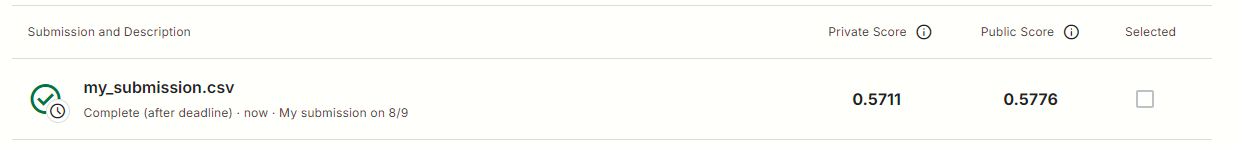

In [43]:
from IPython.display import Image
Image(filename='/kaggle/input/kaggle-submission-pic/Kaggle_submission_pic.PNG') 

<h3>References</h3>

1. https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb